最优解: [0.0, 0.0, 0.0, 1.0]
最优总成本: 694.75


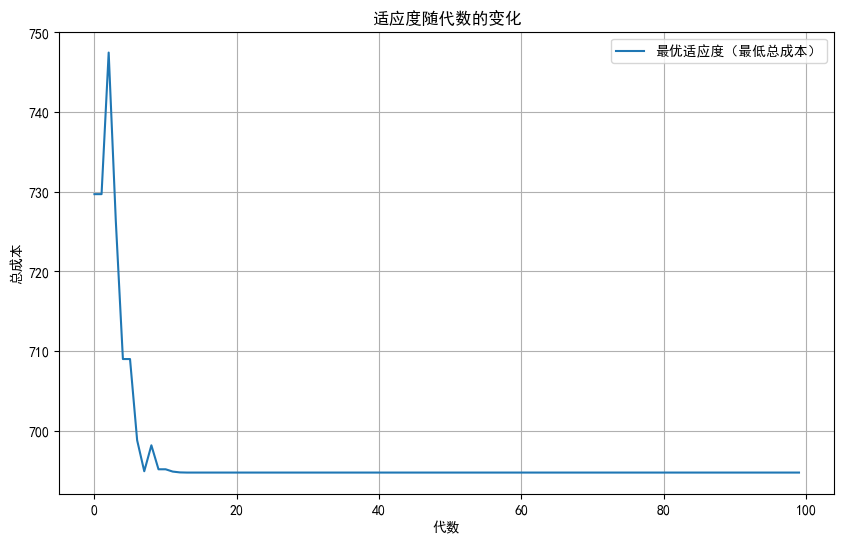

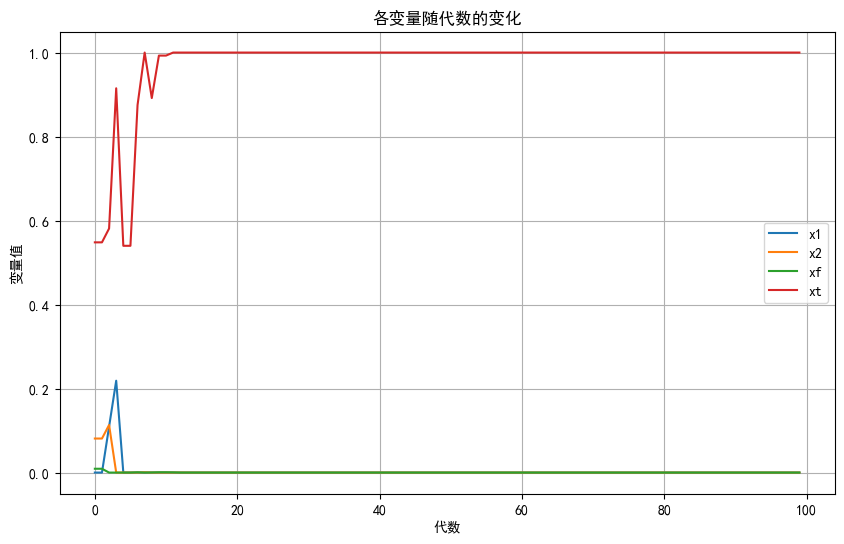

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms

# 定义参数
p1, p2 = 0.1, 0.1  # 零配件 1 和 2 的次品率
Cd1, Cd2 = 2, 3  # 零配件 1 和 2 的检测成本
Cp1, Cp2 = 4, 18  # 零配件 1 和 2 的采购单价
Ca, Cd = 6, 3  # 成品装配成本和检测成本
Ct, Cr = 5, 6  # 拆解费用和调换损失
n1, n2 = 100, 100  # 零配件数量
nf = 90  # 成品数量

# 成品次品率计算函数
def calculate_defect_rate(x1, x2):
    PAa = (1 - x1) * p1 + (1 - x2) * p2 - (1 - x1) * (1 - x2) * p1 * p2
    pf = 1 - (1 - PAa) ** 2
    return pf

# 成本计算函数
def total_cost(x):
    x1, x2, xf, xt = x  # 决策变量
    pf = calculate_defect_rate(x1, x2)
    
    # 零配件检测成本
    C_零配件检测 = x1 * Cd1 * n1 + x2 * Cd2 * n2
    
    # 装配成本
    C_装配 = Ca * nf
    
    # 成品检测成本
    C_成品检测 = xf * Cd * nf
    
    # 拆解和调换成本
    C_拆解 = xt * Ct * pf * nf
    C_调换 = (1 - xt) * Cr * pf * nf
    
    # 总成本
    total_cost = C_零配件检测 + C_装配 + C_成品检测 + C_拆解 + C_调换
    return (total_cost,)  # 返回值要封装成元组

# 解决RuntimeWarning
if "FitnessMin" not in dir(creator):
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
if "Individual" not in dir(creator):
    creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# 定义决策变量的范围
toolbox.register("attr_float", np.random.uniform, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=4)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# 定义适应度函数
toolbox.register("evaluate", total_cost)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# 修复函数，确保所有变量在(0,1)范围内
def check_bounds(individual):
    for i in range(len(individual)):
        if individual[i] < 0:
            individual[i] = 0
        elif individual[i] > 1:
            individual[i] = 1
    return individual

# 装饰交叉和变异函数，以确保解在合理范围内
def mate_and_fix(ind1, ind2):
    tools.cxBlend(ind1, ind2, alpha=0.5)
    check_bounds(ind1)
    check_bounds(ind2)
    return ind1, ind2

def mutate_and_fix(individual):
    tools.mutGaussian(individual, mu=0, sigma=0.2, indpb=0.2)
    check_bounds(individual)
    return individual,

# 注册修饰后的函数
toolbox.register("mate", mate_and_fix)
toolbox.register("mutate", mutate_and_fix)

# 定义遗传算法的参数
population_size = 100
crossover_probability = 0.7
mutation_probability = 0.2
generations = 100

# 初始化种群
population = toolbox.population(n=population_size)

# 存储历史数据以进行可视化
fitness_history = []
x1_history = []
x2_history = []
xf_history = []
xt_history = []

# 运行遗传算法并记录历史数据
for gen in range(generations):
    offspring = algorithms.varAnd(population, toolbox, cxpb=crossover_probability, mutpb=mutation_probability)
    fits = toolbox.map(toolbox.evaluate, offspring)

    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit

    population = toolbox.select(offspring, k=len(population))

    # 记录最优个体的适应度和变量历史
    best_individual = tools.selBest(population, k=1)[0]
    fitness_history.append(best_individual.fitness.values[0])
    x1_history.append(best_individual[0])
    x2_history.append(best_individual[1])
    xf_history.append(best_individual[2])
    xt_history.append(best_individual[3])

# 获取最终最优解
best_individual = tools.selBest(population, k=1)[0]
optimal_solution = best_individual
optimal_cost = total_cost(optimal_solution)[0]

print(f"最优解: {optimal_solution}")
print(f"最优总成本: {optimal_cost:.2f}")

# 设置中文字体（使用SimHei字体）
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 可视化适应度随代数变化
plt.figure(figsize=(10, 6))
plt.plot(fitness_history, label="最优适应度（最低总成本）")
plt.xlabel("代数")
plt.ylabel("总成本")
plt.title("适应度随代数的变化")
plt.legend()
plt.grid(True)
plt.show()

# 可视化各变量随代数变化
plt.figure(figsize=(10, 6))
plt.plot(x1_history, label="x1")
plt.plot(x2_history, label="x2")
plt.plot(xf_history, label="xf")
plt.plot(xt_history, label="xt")
plt.xlabel("代数")
plt.ylabel("变量值")
plt.title("各变量随代数的变化")
plt.legend()
plt.grid(True)
plt.show()

In [24]:
from pyswarm import pso
# 决策变量的边界
lb = [0, 0, 0, 0]  # 下界
ub = [1, 1, 1, 1]  # 上界

# 运行粒子群优化算法
optimal_solution, optimal_cost = pso(total_cost, lb, ub, swarmsize=100, maxiter=200)

print(f"最优解: {optimal_solution}")
print(f"最优总成本: {optimal_cost:.2f}")

ModuleNotFoundError: No module named 'pyswarm'

Stopping search: maximum iterations reached --> 200
最优解: [0. 0. 0. 1.]
最优总成本: 694.75

这个不稳定，你们看情况使用

正在优化情况 1...
情况 1 最优解: [0.0, 0.0, 0.0, 1.0]
情况 1 最优总成本: 694.75
正在优化情况 2...
情况 2 最优解: [0.0, 0.0, 0.0, 1.0]
情况 2 最优总成本: 805.68
正在优化情况 3...
情况 3 最优解: [0.0, 0.0, 0.0, 1.0]
情况 3 最优总成本: 694.75
正在优化情况 4...
情况 4 最优解: [1.0, 1.0, 0.0, 0.3941339439541425]
情况 4 最优总成本: 740.00
正在优化情况 5...
情况 5 最优解: [0.0, 1.0, 0.0, 1.0]
情况 5 最优总成本: 725.50
正在优化情况 6...
情况 6 最优解: [0.0, 0.0, 0.0, 0.0]
情况 6 最优总成本: 706.94


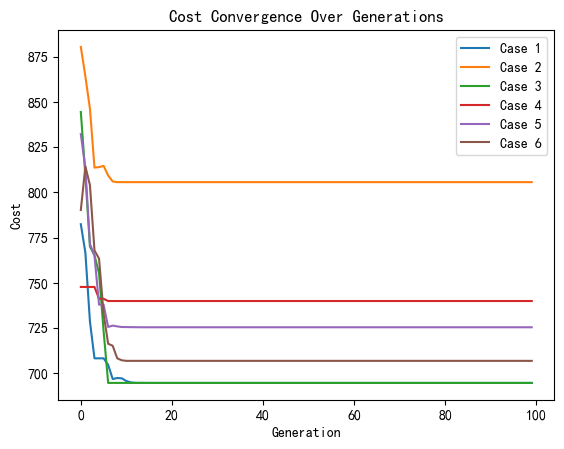

In [44]:
import numpy as np
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt  # 导入matplotlib

# 定义数据列表
data = [
    [0.1, 4, 2, 0.1, 18, 3, 0.1, 6, 3, 56, 6, 5],    # 情况 1
    [0.2, 4, 2, 0.2, 18, 3, 0.2, 6, 3, 56, 6, 5],    # 情况 2
    [0.1, 4, 2, 0.1, 18, 3, 0.1, 6, 3, 56, 30, 5],   # 情况 3
    [0.2, 4, 1, 0.2, 18, 1, 0.2, 6, 2, 56, 30, 5],   # 情况 4
    [0.1, 4, 8, 0.2, 18, 1, 0.1, 6, 2, 56, 10, 5],   # 情况 5
    [0.05, 4, 2, 0.05, 18, 3, 0.05, 6, 3, 56, 10, 40]  # 情况 6
]

# 准备数据并创建案例
cases = []
for i, row in enumerate(data):
    case = {
        "p1": row[0],  # 零配件1次品率
        "Cd1": row[2], # 零配件1检测成本
        "Cp1": row[1], # 零配件1采购单价
        "p2": row[3],  # 零配件2次品率
        "Cd2": row[5], # 零配件2检测成本
        "Cp2": row[4], # 零配件2采购单价
        "pf": row[6],  # 成品次品率
        "Ca": row[7],  # 成品装配成本
        "Cd": row[8],  # 成品检测成本
        "Cr": row[10], # 调换损失
        "Ct": row[11], # 拆解费用
        "n1": 100,     # 零配件1数量
        "n2": 100,     # 零配件2数量
        "nf": 90       # 成品数量
    }
    cases.append(case)

# 成本计算函数
def total_cost(x, case):
    x1, x2, xf, xt = x  # 决策变量
    p1, Cd1, Cp1, p2, Cd2, Cp2, pf, Ca, Cd, Cr, Ct, n1, n2, nf = case.values()

    # 计算成品次品率
    PAa = (1 - x1) * p1 + (1 - x2) * p2 - (1 - x1) * (1 - x2) * p1 * p2
    pf = 1 - (1 - PAa) ** 2
    
    # 零配件检测成本
    C_零配件检测 = x1 * Cd1 * n1 + x2 * Cd2 * n2
    
    # 装配成本
    C_装配 = Ca * nf
    
    # 成品检测成本
    C_成品检测 = xf * Cd * nf
    
    # 拆解和调换成本
    C_拆解 = xt * Ct * pf * nf
    C_调换 = (1 - xt) * Cr * pf * nf
    
    # 总成本
    total_cost = C_零配件检测 + C_装配 + C_成品检测 + C_拆解 + C_调换
    return (total_cost,)

# 解决RuntimeWarning
if "FitnessMin" not in dir(creator):
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
if "Individual" not in dir(creator):
    creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# 定义决策变量的范围
toolbox.register("attr_float", np.random.uniform, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=4)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# 定义适应度函数
def evaluate(individual, case):
    return total_cost(individual, case)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# 修复函数，确保所有变量在(0,1)范围内
def check_bounds(individual):
    for i in range(len(individual)):
        if individual[i] < 0:
            individual[i] = 0
        elif individual[i] > 1:
            individual[i] = 1
    return individual

# 装饰交叉和变异函数，以确保解在合理范围内
def mate_and_fix(ind1, ind2):
    tools.cxBlend(ind1, ind2, alpha=0.5)
    check_bounds(ind1)
    check_bounds(ind2)
    return ind1, ind2

def mutate_and_fix(individual):
    tools.mutGaussian(individual, mu=0, sigma=0.2, indpb=0.2)
    check_bounds(individual)
    return individual,

# 注册修饰后的函数
toolbox.register("mate", mate_and_fix)
toolbox.register("mutate", mutate_and_fix)

# 定义遗传算法的参数
population_size = 100
crossover_probability = 0.7
mutation_probability = 0.2
generations = 100

# 初始化结果存储
results = []

# 针对每个情况运行遗传算法
for i, case in enumerate(cases):
    print(f"正在优化情况 {i+1}...")
    
    # 初始化种群
    population = toolbox.population(n=population_size)
    
    # 保存每一代的最佳成本
    best_costs = []

    # 运行遗传算法
    for gen in range(generations):
        offspring = algorithms.varAnd(population, toolbox, cxpb=crossover_probability, mutpb=mutation_probability)
        fits = toolbox.map(lambda ind: toolbox.evaluate(ind, case), offspring)

        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit

        population = toolbox.select(offspring, k=len(population))

        # 保存当前代的最佳成本
        best_individual = tools.selBest(population, k=1)[0]
        best_cost = total_cost(best_individual, case)[0]
        best_costs.append(best_cost)

    # 获取最终最优解
    optimal_solution = best_individual
    optimal_cost = best_cost

    print(f"情况 {i+1} 最优解: {optimal_solution}")
    print(f"情况 {i+1} 最优总成本: {optimal_cost:.2f}")
    
    # 存储结果
    results.append({
        "Case": i+1,
        "Optimal Solution": optimal_solution,
        "Optimal Cost": optimal_cost,
        "Best Costs": best_costs  # 保存成本变化
    })

# 绘制每个情况的成本变化曲线
for result in results:
    plt.plot(result["Best Costs"], label=f"Case {result['Case']}")

plt.xlabel('Generation')
plt.ylabel('Cost')
plt.title('Cost Convergence Over Generations')
plt.legend()
plt.show()


全局策略分析：
大部分情况下（情况 1、2、3），最优解为 [0.0, 0.0, 0.0, 1.0]，表明在这些条件下，选择第四个策略（可能是工序拆解或某种特定的生产操作）是最优的。
成本比较：
不同情况下的总成本有所不同，最高为情况 2 的 805.68，最低为情况 1 和 3 的 694.75。
策略差异性：
在情况 4、5、6 中，策略组合变得更加复杂，说明这些情况下的生产条件发生了变化，需要更精细的策略组合来达到最优成本。

最优解: [0.3333333333333333, 0.8888888888888888, 1.0, 0.8888888888888888]
最优总成本: 19392.78


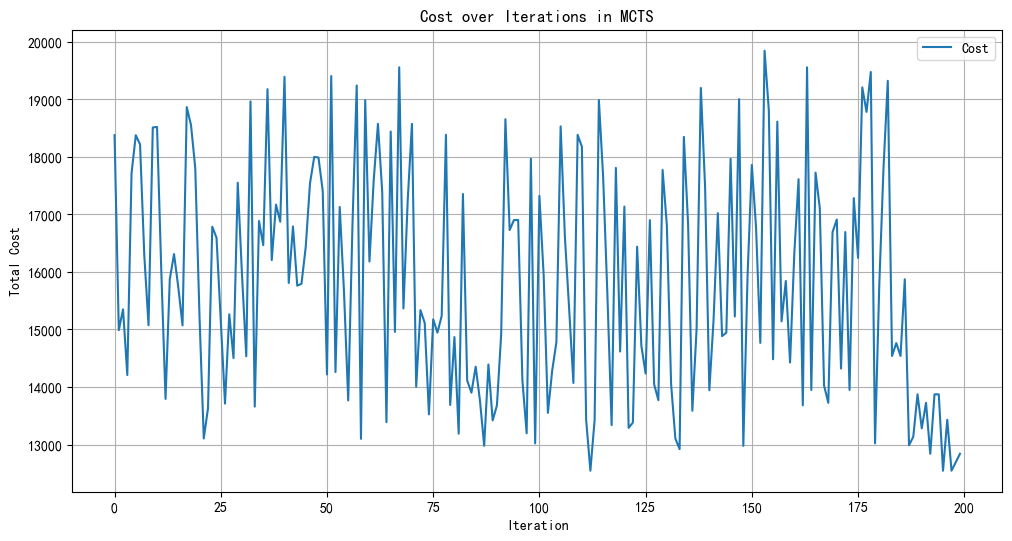

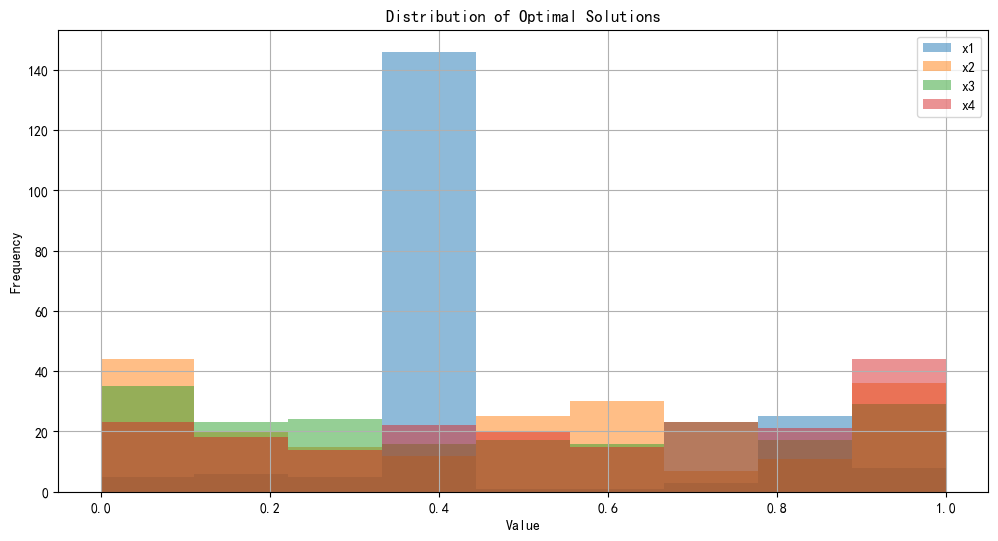

In [46]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt

# 离散化参数
num_intervals = 10  # 将0-1区间分成10个等间隔
values = np.linspace(0, 1, num_intervals)

# 模拟的参数 (用实例数据代替)
p1, p2 = 0.1, 0.2
Cd1, Cd2 = 10, 20
Ca, Cd, Ct, Cr = 50, 30, 40, 25
n1, n2, nf = 100, 100, 200

# 成品次品率计算函数
def calculate_defect_rate(x1, x2):
    PAa = (1 - x1) * p1 + (1 - x2) * p2 - (1 - x1) * (1 - x2) * p1 * p2
    pf = 1 - (1 - PAa) ** 2
    return pf


# MCTS 节点类
class MCTSNode:
    def __init__(self, parent=None, value=None):
        self.parent = parent
        self.children = {}
        self.visits = 0
        self.value = value
        self.total_cost = 0
    
    def is_fully_expanded(self):
        return len(self.children) == num_intervals

    def best_child(self, c_param=1.4):
        best_child = None
        best_score = float('inf')
        
        for child in self.children.values():
            ucb1 = (child.total_cost / (child.visits + 1e-8) + 
                    c_param * math.sqrt((2 * math.log(self.visits) / (child.visits + 1e-8))))
            if ucb1 < best_score:
                best_score = ucb1
                best_child = child
                
        return best_child

# MCTS 搜索函数
def mcts_search(root, iterations):
    costs = []
    solutions = []

    for _ in range(iterations):
        node = root
        state = []  # 保存路径

        # 选择阶段
        while node.is_fully_expanded() and len(state) < 4:
            node = node.best_child()
            state.append(node.value)

        # 扩展阶段
        if len(state) < 4:  # 4个变量还未完全探索
            next_value = random.choice(values)
            state.append(next_value)
            new_node = MCTSNode(parent=node, value=next_value)
            node.children[next_value] = new_node
            node = new_node

        # 模拟阶段
        while len(state) < 4:
            state.append(random.choice(values))

        # 计算成本
        cost = total_cost(state)

        # 记录每次迭代的最优解和成本
        costs.append(cost)
        solutions.append(state.copy())

        # 反向传播阶段
        while node is not None:
            node.visits += 1
            node.total_cost += cost
            node = node.parent

    # 返回最优解和成本记录
    best_child = root.best_child(c_param=0)
    optimal_solution = []
    current_node = best_child
    while current_node is not None:
        if current_node.value is not None:
            optimal_solution.insert(0, current_node.value)
        current_node = current_node.parent
    
    while len(optimal_solution) < 4:
        optimal_solution.append(random.choice(values))
    
    return optimal_solution, costs, solutions

# 初始化根节点并运行MCTS
root = MCTSNode()
iterations = 200
optimal_solution, costs, solutions = mcts_search(root, iterations=iterations)
optimal_cost = total_cost(optimal_solution)

print(f"最优解: {optimal_solution}")
print(f"最优总成本: {optimal_cost:.2f}")

# 可视化成本变化曲线
plt.figure(figsize=(12, 6))
plt.plot(range(iterations), costs, label='Cost')
plt.xlabel('Iteration')
plt.ylabel('Total Cost')
plt.title('Cost over Iterations in MCTS')
plt.legend()
plt.grid(True)
plt.show()

# 可视化最优解的分布
plt.figure(figsize=(12, 6))
solutions_array = np.array(solutions)
for i in range(4):
    plt.hist(solutions_array[:, i], bins=np.linspace(0, 1, num_intervals), alpha=0.5, label=f'x{i+1}')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Optimal Solutions')
plt.legend()
plt.grid(True)
plt.show()

这个不稳定，可看情况使用